In [19]:
# [Cell 1: 데이터 가져오기]
import sys

import numpy as np
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from pandas.core.array_algos.masked_accumulations import cumprod
from sqlalchemy import create_engine
from sqlalchemy.util import symbol

sys.path.append('../')
DB_URI = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(DB_URI)

# QQQ 데이터만 가져오기
query = "select trade_date, close_price from practice_spy where ticker = 'QQQ' order by trade_date asc"
df = pd.read_sql(query, engine)
df.set_index('trade_date', inplace=True)
print("데이터 로딩 완료")


데이터 로딩 완료


In [20]:
# [Cell 2: 판다스로 이동평균선 만들기] SQL로도 할 수 있지만, 판다스에는 .rolling()이라는 아주 편한 함수가 있습니다.
# 이동평균선 계산
df['MA5'] = df['close_price'].rolling(window=5).mean()  # 5일선
df['MA20'] = df['close_price'].rolling(window=20).mean() # 20일선

# 골든크로스/데드크로스 신호 찾기 (심화 로직!)
# 1. 어제는 5일선이 20일선보다 낮았는데 (<)
# 2. 오늘은 5일선이 20일선보다 높아졌다면 (>) => 골든크로스(Buy)!
df['Signal'] = 0
df.loc[(df['MA5'] > df['MA20']) & (df['MA5'].shift(1) <= df['MA20'].shift(1)), 'Signal'] = 1 # 매수
df.loc[(df['MA5'] < df['MA20']) & (df['MA5'].shift(1) >= df['MA20'].shift(1)), 'Signal'] = -1 # 매도

print(df.tail(10)) # 끝부분 데이터 확인

            close_price      MA5      MA20  Signal
trade_date                                        
2025-11-17       596.31  607.662  618.2100       0
2025-11-18       599.87  603.420  617.9290       0
2025-11-19       585.67  598.874  616.6835       0
2025-11-20       590.07  595.116  615.3320       0
2025-11-23       605.16  595.416  614.1855       0
2025-11-24       608.89  597.932  612.9840       0
2025-11-25       614.27  600.812  611.9090       0
2025-11-27       619.25  607.528  611.5690       0
2025-11-30       617.17  612.948  610.9740       1
2025-12-01       622.00  616.316  610.4700       0


In [21]:
# [Cell 3: 결정적 순간 시각화 (Plotly)]
# 차트 그리기
fig = go.Figure()

# 1. 주가 선 (얇게)
fig.add_trace(go.Scatter(x=df.index, y=df['close_price'], name='Price', line=dict(color='gray', width=1)))

# 2. 이동평균선
fig.add_trace(go.Scatter(x=df.index, y=df['MA5'], name='MA5 (Fast)', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20 (Slow)', line=dict(color='orange', width=2)))

# 3. 매수 신호 (골든크로스) - 빨간 세모 ▲
buy_signals = df[df['Signal'] == 1]
fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['close_price'], mode='markers',
                         marker=dict(symbol='triangle-up', size=12, color='red'), name='Buy Signal'))

# 4. 매도 신호 (데드크로스) - 파란 세모 ▼
sell_signals = df[df['Signal'] == -1]
fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['close_price'], mode='markers',
                         marker=dict(symbol='triangle-down', size=12, color='blue'), name='Sell Signal'))

fig.update_layout(title='QQQ Moving Average Strategy (Golden Cross)', hovermode="x unified")
fig.show()

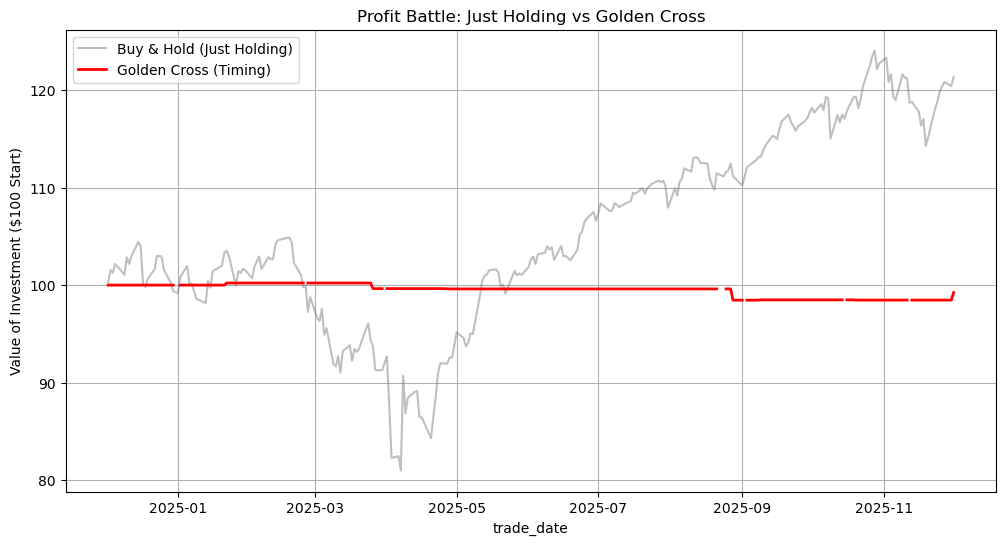

=== 💰 최종 성적표 (100만원 투자 시) ===
1. 그냥 존버했으면: 121 만원
2. 골든크로스 매매: 99 만원


In [22]:
# 1. 포지션 정하기 (1: 보유 중, 0: 현금 보유)
# 신호가 1(매수)이면 계속 1을 유지하다가, -1(매도)이 뜨면 0으로 바꿈
df['Position'] = df['Signal'].replace(to_replace=-1, value=np.nan)
df['Position'] = df['Position'].replace(-1, 0)

# 2. 수익률 계산
# 시장 수익률 (QQQ를 그냥 들고 있었을 때)
df['Market_Return'] = df['close_price'].pct_change()

# 전략 수익률 (신호대로 사고 팔았을 때)
# shift(1)을 하는 이유: 신호를 보고 '다음 날' 시초가에 산다고 가정 (현실적)
df['Strategy_Return'] = df['Market_Return'] * df['Position'].shift(1)

# 3. 누적 수익률 (100원으로 시작했을 때)
df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod() * 100
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod() * 100

# 4. 결과 그래프
plt.figure(figsize=(12, 6))
df['Cumulative_Market'].plot(label='Buy & Hold (Just Holding)', color='gray', alpha=0.5)
df['Cumulative_Strategy'].plot(label='Golden Cross (Timing)', color='red', linewidth=2)

plt.title('Profit Battle: Just Holding vs Golden Cross')
plt.legend()
plt.grid(True)
plt.ylabel('Value of Investment ($100 Start)')
plt.show()

# 5. 최종 결과 출력
final_market = df['Cumulative_Market'].iloc[-1]
final_strategy = df['Cumulative_Strategy'].iloc[-1]

print(f"=== 💰 최종 성적표 (100만원 투자 시) ===")
print(f"1. 그냥 존버했으면: {final_market:.0f} 만원")
print(f"2. 골든크로스 매매: {final_strategy:.0f} 만원")

🔄 최적의 숫자를 찾는 중... (잠시만 기다리세요)
⚡ 발견! 3일 vs 20일 -> 수익률: 13.5%
⚡ 발견! 3일 vs 21일 -> 수익률: 14.9%
⚡ 발견! 3일 vs 22일 -> 수익률: 16.4%
⚡ 발견! 3일 vs 23일 -> 수익률: 21.9%
⚡ 발견! 3일 vs 25일 -> 수익률: 22.5%
⚡ 발견! 3일 vs 26일 -> 수익률: 23.1%
⚡ 발견! 3일 vs 27일 -> 수익률: 24.4%
⚡ 발견! 3일 vs 33일 -> 수익률: 25.2%
⚡ 발견! 3일 vs 37일 -> 수익률: 27.9%
⚡ 발견! 4일 vs 37일 -> 수익률: 28.9%

=== 🏆 최종 우승 조합: 4일(단기) vs 37일(장기) ===


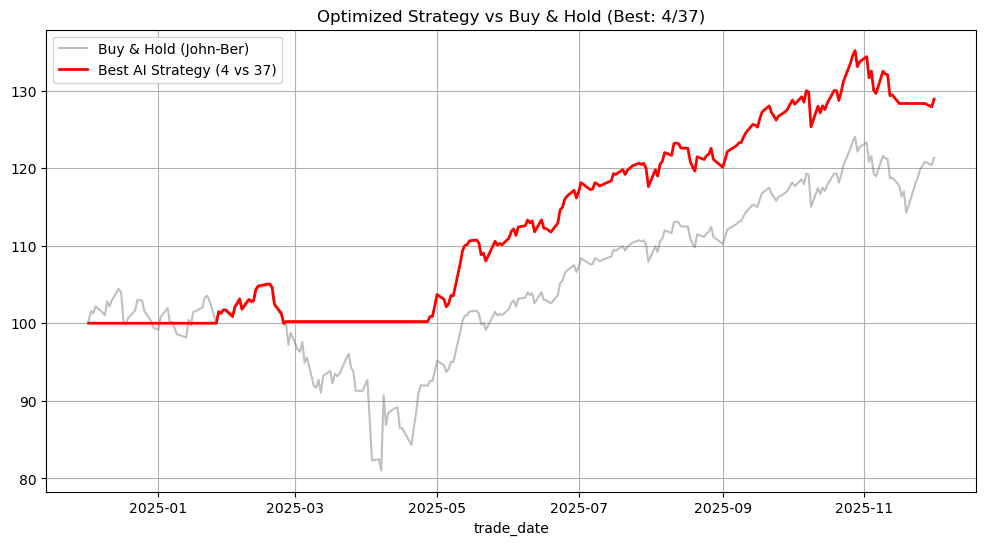

In [24]:
print("🔄 최적의 숫자를 찾는 중... (잠시만 기다리세요)")

# 단기 이평선: 3일 ~ 20일
for short_window in range(3, 21):
    # 장기 이평선: 20일 ~ 60일
    for long_window in range(20, 61):
        if short_window >= long_window: continue # 단기가 장기보다 길면 안 됨

        # 전략 시뮬레이션 (임시 데이터프레임 사용)
        temp_df = df.copy()
        temp_df['S'] = temp_df['close_price'].rolling(window=short_window).mean()
        temp_df['L'] = temp_df['close_price'].rolling(window=long_window).mean()

        # 신호 만들기 (1: 보유, 0: 현금)
        temp_df['Signal'] = np.where(temp_df['S'] > temp_df['L'], 1, 0)
        temp_df['Position'] = temp_df['Signal'].shift(1) # 다음날 시초가 매매 가정

        # 수익률 계산
        temp_df['Market_Ret'] = temp_df['close_price'].pct_change()
        temp_df['Strategy_Ret'] = temp_df['Market_Ret'] * temp_df['Position']

        # 누적 수익률
        final_return = (1 + temp_df['Strategy_Ret']).cumprod().iloc[-1]

        # 최고 기록 갱신하면 저장
        if final_return > best_score:
            best_score = final_return
            best_short = short_window
            best_long = long_window
            print(f"⚡ 발견! {short_window}일 vs {long_window}일 -> 수익률: {(final_return-1)*100:.1f}%")

# 3. 최적의 결과 vs 존버 비교 그래프
print(f"\n=== 🏆 최종 우승 조합: {best_short}일(단기) vs {best_long}일(장기) ===")

# 최적 조합으로 다시 계산해서 그리기
df['MA_Short'] = df['close_price'].rolling(window=best_short).mean()
df['MA_Long'] = df['close_price'].rolling(window=best_long).mean()
df['Position'] = np.where(df['MA_Short'] > df['MA_Long'], 1, 0)
df['Strategy_Ret'] = df['close_price'].pct_change() * pd.Series(df['Position']).shift(1).fillna(0)

# 100으로 지수화
df['Buy_Hold'] = (1 + df['close_price'].pct_change()).cumprod() * 100
df['Best_Strategy'] = (1 + df['Strategy_Ret']).cumprod() * 100

plt.figure(figsize=(12, 6))
df['Buy_Hold'].plot(label='Buy & Hold (John-Ber)', color='gray', alpha=0.5)
df['Best_Strategy'].plot(label=f'Best AI Strategy ({best_short} vs {best_long})', color='red', linewidth=2)

plt.title(f'Optimized Strategy vs Buy & Hold (Best: {best_short}/{best_long})')
plt.legend()
plt.grid(True)
plt.show()